## Dataset & augmentation

In [1]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=08e5e58617d9fe422c15d87d21d8d02dc220c6299352e2799968c99e1fd84f86
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [ ]:
import wget

# The dataset we used belongs to Leaf Segmentation and Counting Challenge (LCC and LSC). 
# It is publicly available at https://www.plant-phenotyping.org/CVPPP2017. 
# The data download links are saved to the dataset_urls.txt file.

train_truth_url, train_url, test_url = open("dataset_urls.txt").readlines()

train_h5 = wget.download(train_url)
train_truth_h5 = wget.download(train_truth_url)
test_h5 = wget.download(test_url)

In [ ]:
!unzip 'CVPPP2017_training_images.zip'
!unzip 'CVPPP2017_training_truth.zip'
!unzip 'CVPPP2017_testing_images.zip'

Archive:  CVPPP2017_training_images.zip
  inflating: CVPPP2017_training_images.h5  
Archive:  CVPPP2017_training_truth.zip
  inflating: CVPPP2017_training_truth.h5  
Archive:  CVPPP2017_testing_images.zip
  inflating: CVPPP2017_testing_images.h5  


In [ ]:
import h5py

import numpy as np

groups = ['A1', 'A2', 'A3']

train_filename = 'CVPPP2017_training_images.h5'
train_imgs = []
with h5py.File(train_filename, "r") as f:
    for group in groups:
        for file_name in list(f[group]):
            train_imgs.append(np.moveaxis(np.array(f[group][file_name]['rgb'])[:, :, :3], [2], [0]) / 255)


train_truth_filename = 'CVPPP2017_training_truth.h5'
train_counts = []
train_masks = []
with h5py.File(train_truth_filename, "r") as f:
    for group in groups:
        for file_name in list(f[group]):
            train_counts.append(np.array(f[group][file_name]['count']))
            train_masks.append(np.clip(np.array(f[group][file_name]['label']), 0, 1))

In [ ]:
import random

train_lst = list(zip(train_imgs, train_counts, train_masks))
random.shuffle(train_lst)
train_imgs, train_counts, train_masks = list(zip(*train_lst))

In [ ]:
print(f"Images: {len(train_imgs)}, Counts: {len(train_counts)}, Masks: {len(train_masks)}")

Images: 186, Counts: 186, Masks: 186


The number of leafs: 14


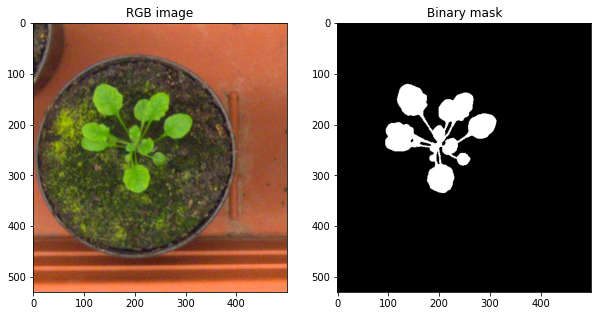

In [ ]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(1,2)

axarr[0].imshow(np.moveaxis(train_imgs[0], [0], [2]))
axarr[0].set_title('RGB image')
axarr[1].imshow(train_masks[0], cmap='gray')
axarr[1].set_title('Binary mask')

f.set_figheight(10)
f.set_figwidth(10)


print('The number of leafs:', train_counts[0])

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
import random

# Separating positional from coloring transformations.
# This helps to match the position of the mask and the plant on image.
positional_transforms = transforms.Compose([torch.Tensor,
    transforms.Resize((480, 480)),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

coloring_transforms = transforms.Compose([
    transforms.RandomApply([transforms.RandomGrayscale(p=0.1)], p=0.5),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4)
])


class LeafDataset(Dataset):
    def __init__(self, imgs, masks, counts, pos_transf=torch.Tensor, color_transf=None):
        super().__init__()
        self.images = imgs
        self.masks = masks
        self.counts = counts
        self.pos_transforms = pos_transf
        self.color_transforms = color_transf
    
    def __len__(self):
        return len(self.images)

    def _set_seed(self, seed):
        random.seed(seed)
        torch.manual_seed(seed)
        
    def __getitem__(self, idx):
        # Positional augmentaion
        seed = random.randint(0, 2**32)
        self._set_seed(seed)
        aug_img = self.pos_transforms(self.images[idx])
        self._set_seed(seed)
        aug_mask = self.pos_transforms(np.expand_dims(self.masks[idx], 0))

        # Coloring augmentaion
        if self.color_transforms:
            aug_img = self.color_transforms(aug_img)
        return aug_img, self.counts[idx], aug_mask


In [ ]:
# Should delete the test dataset and rename the variables
from tqdm.notebook import tqdm

batch_size = 4
train_size = 0.8
dataset_len = len(train_imgs)
train_len = int(dataset_len * train_size)

train_dataset = LeafDataset(train_imgs[:train_len], train_masks[:train_len], train_counts[:train_len], positional_transforms, coloring_transforms)
test_dataset = LeafDataset(train_imgs[train_len:], train_masks[train_len:], train_counts[train_len:], positional_transforms, coloring_transforms)

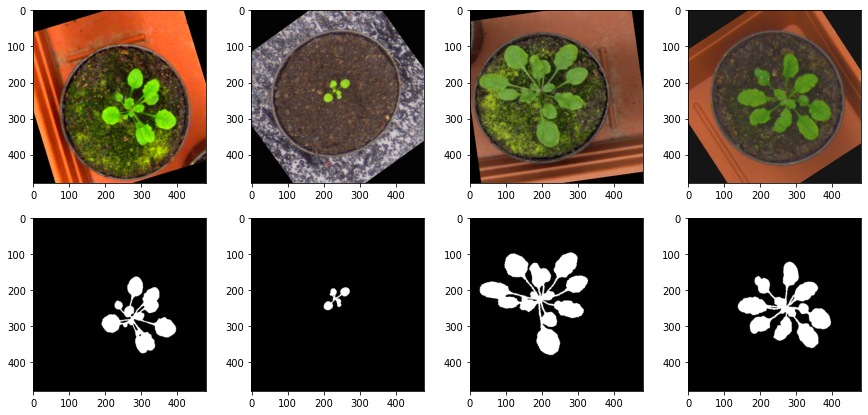

In [ ]:
# Augmentaion example

aug_example_iter = iter(train_dataset)

im1, _, mask1 = next(aug_example_iter)
im2, _, mask2 = next(aug_example_iter)
im3, _, mask3 = next(aug_example_iter)
im4, _, mask4 = next(aug_example_iter)

aug_images = [im1, im2, im3, im4]
aug_masks = [mask1, mask2, mask3, mask4]

f, axarr = plt.subplots(2, 4)

for i in range(4):
    axarr[0, i].imshow(torch.moveaxis(aug_images[i], [0], [2]))
    axarr[1, i].imshow(aug_masks[i].squeeze(0), cmap='gray')

f.set_figheight(7)
f.set_figwidth(15)

In [ ]:
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

## Build models

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from time import time
from tqdm.notebook import tqdm

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Working on {device} device')

Working on cuda device


# UNet 

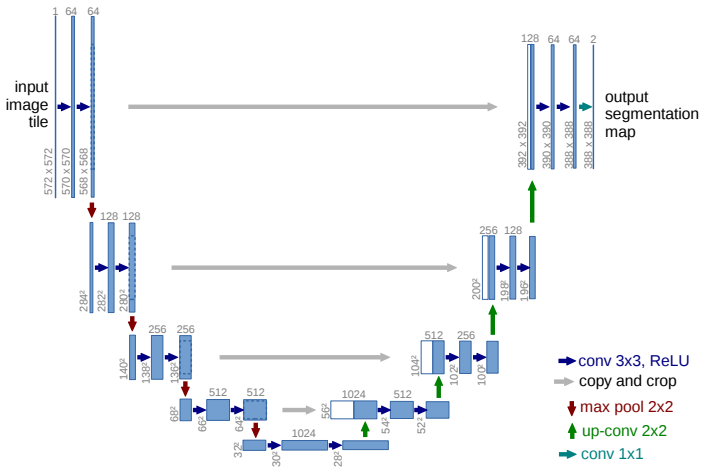

In [ ]:
# First segmentation network

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv1 = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
                                       nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2, 2)  # 256 -> 128
        
        self.enc_conv2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
                                       nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2, 2)  # 128 -> 64

        self.enc_conv3 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
                                       nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
                                       nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU())
        self.pool3 = nn.MaxPool2d(2, 2)  # 64 -> 32

        self.enc_conv4 = nn.Sequential(nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
                                       nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
                                       nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU())
        self.pool4 = nn.MaxPool2d(2, 2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(512, 1024, 3, padding=1), nn.BatchNorm2d(1024), nn.ReLU(),
                                       nn.Conv2d(1024, 1024, 3, padding=1), nn.BatchNorm2d(1024), nn.ReLU())

        # decoder (upsampling)
        self.upsample1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)  # 16 -> 32
        self.dec_conv1 = nn.Sequential(nn.Conv2d(1024, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
                                       nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU())
        
        self.upsample2 = nn.ConvTranspose2d(512, 256, 2, stride=2)  # 32 -> 64
        self.dec_conv2 = nn.Sequential(nn.Conv2d(512, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
                                       nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU())
        
        self.upsample3 = nn.ConvTranspose2d(256, 128, 2, stride=2)  # 64 -> 128
        self.dec_conv3 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
                                       nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU())

        self.upsample4 = nn.ConvTranspose2d(128, 64, 2, stride=2)   # 128 -> 256
        self.dec_conv4 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
                                       nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
                                       nn.Conv2d(64, 1, 1))


    def forward(self, x):
        # encoder
        e1 = self.enc_conv1(x)
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))
        e4 = self.enc_conv4(self.pool3(e3))

        # bottleneck
        b = self.bottleneck_conv(self.pool4(e4))


        # decoder
        d1 = self.dec_conv1(torch.concat([e4, self.upsample1(b)], 1))
        d2 = self.dec_conv2(torch.concat([e3, self.upsample2(d1)], 1))
        d3 = self.dec_conv3(torch.concat([e2, self.upsample3(d2)], 1))
        d4 = self.dec_conv4(torch.concat([e1, self.upsample4(d3)], 1)) # no activation

        return torch.sigmoid(d4)

# UNet++



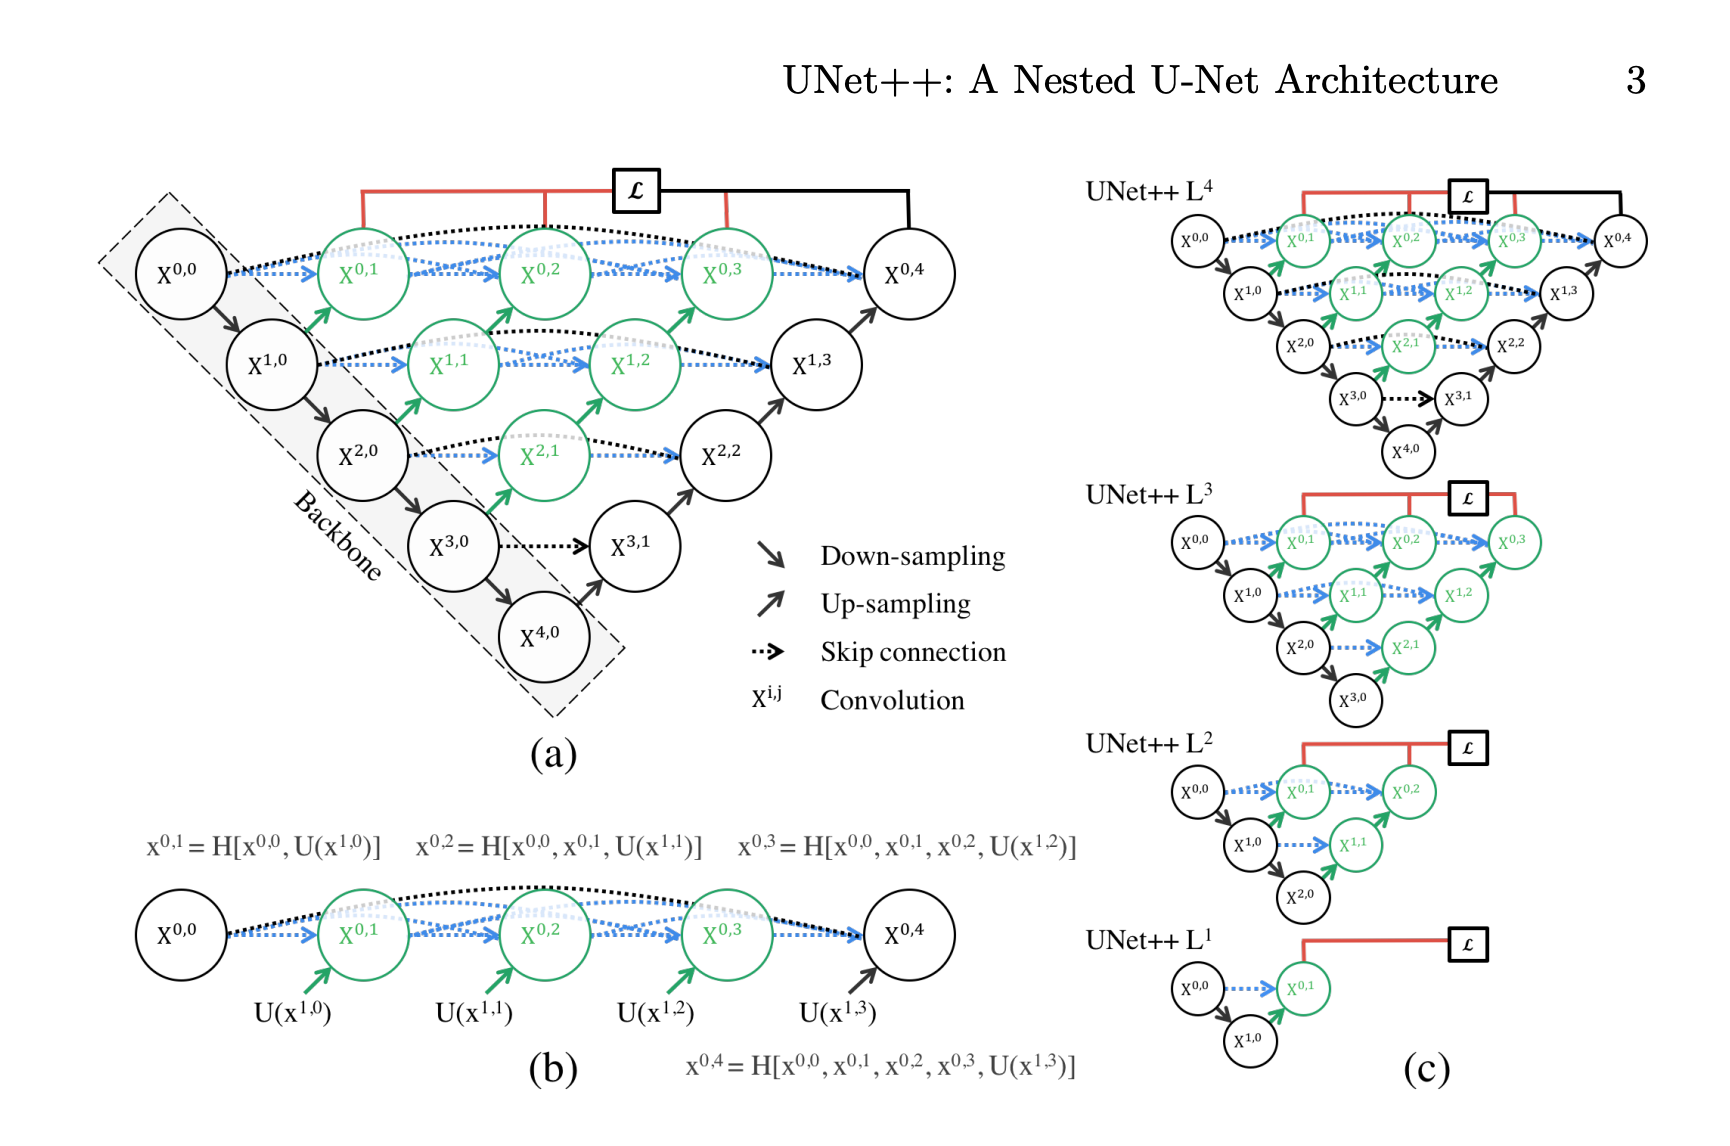

In [ ]:
# Second segmentation network
# Find the original paper on Unet++ at https://arxiv.org/pdf/1807.10165.pdf

class ConvBlock(nn.Module):
    """
    Referred as H in the orginal paper.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)


class UNetPlusPlus(nn.Module):
    def __init__(self):
        
        super().__init__()

        # Layer 0 (Backbone)
        self.conv_block_0_0 = ConvBlock(3, 64)
        self.pool1 = nn.MaxPool2d(2, 2)  # 480 -> 240
        self.conv_block_1_0 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2, 2)  # 240 -> 120
        self.conv_block_2_0 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2, 2)  # 120 -> 60
        self.conv_block_3_0 = ConvBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2, 2)  # 60 -> 30
        self.conv_block_4_0 = ConvBlock(512, 1024)

        # Layer 1
        self.upsample_1_0 = nn.ConvTranspose2d(128, 64, 2, stride=2)  # 240 -> 480
        self.conv_block_0_1 = ConvBlock(2 * 64, 64)
        self.upsample_2_0 = nn.ConvTranspose2d(256, 128, 2, stride=2)  # 120 -> 240
        self.conv_block_1_1 = ConvBlock(2 * 128, 128)
        self.upsample_3_0 = nn.ConvTranspose2d(512, 256, 2, stride=2)  # 60 -> 120
        self.conv_block_2_1 = ConvBlock(2 * 256, 256)
        self.upsample_4_0 = nn.ConvTranspose2d(1024, 512, 2, stride=2)  # 30 -> 60
        self.conv_block_3_1 = ConvBlock(2 * 512, 512)

        # Layer 2
        self.upsample_1_1 = nn.ConvTranspose2d(128, 64, 2, stride=2)  # 240 -> 480
        self.conv_block_0_2 = ConvBlock(3 * 64, 64)
        self.upsample_2_1 = nn.ConvTranspose2d(256, 128, 2, stride=2)  # 120 -> 240
        self.conv_block_1_2 = ConvBlock(3 * 128, 128)
        self.upsample_3_1 = nn.ConvTranspose2d(512, 256, 2, stride=2)  # 60 -> 120
        self.conv_block_2_2 = ConvBlock(3 * 256, 256)
        
        # Layer 3
        self.upsample_1_2 = nn.ConvTranspose2d(128, 64, 2, stride=2)  # 240 -> 480
        self.conv_block_0_3 = ConvBlock(4 * 64, 64)
        self.upsample_2_2 = nn.ConvTranspose2d(256, 128, 2, stride=2)  # 120 -> 240
        self.conv_block_1_3 = ConvBlock(4 * 128, 128)
        
        # Layer 4 (last layer)
        self.upsample_1_3 = nn.ConvTranspose2d(128, 64, 2, stride=2)  # 240 -> 480
        self.conv_block_0_4 = ConvBlock(5 * 64, 64)

        # 1x1 Convolutions + sigmoid for Deep Supervision
        self.ds_0_1 = nn.Sequential(nn.Conv2d(64, 1, 1), nn.Sigmoid())
        self.ds_0_2 = nn.Sequential(nn.Conv2d(64, 1, 1), nn.Sigmoid())
        self.ds_0_3 = nn.Sequential(nn.Conv2d(64, 1, 1), nn.Sigmoid())
        self.ds_0_4 = nn.Sequential(nn.Conv2d(64, 1, 1), nn.Sigmoid())


    def forward(self, x):
        # Compute layer 0 (Backbone)
        x0_0 = self.conv_block_0_0(x)
        x1_0 = self.conv_block_1_0(self.pool1(x0_0))
        x2_0 = self.conv_block_2_0(self.pool2(x1_0))
        x3_0 = self.conv_block_3_0(self.pool3(x2_0))
        x4_0 = self.conv_block_4_0(self.pool4(x3_0))

        
        # Compute layer 1
        x0_1 = self.conv_block_0_1(torch.cat([x0_0, self.upsample_1_0(x1_0)], axis=1))
        x1_1 = self.conv_block_1_1(torch.cat([x1_0, self.upsample_2_0(x2_0)], axis=1))
        x2_1 = self.conv_block_2_1(torch.cat([x2_0, self.upsample_3_0(x3_0)], axis=1))
        x3_1 = self.conv_block_3_1(torch.cat([x3_0, self.upsample_4_0(x4_0)], axis=1))

        # Compute layer 2
        x0_2 = self.conv_block_0_2(torch.cat([x0_0, x0_1, self.upsample_1_1(x1_1)], axis=1))
        x1_2 = self.conv_block_1_2(torch.cat([x1_0, x1_1, self.upsample_2_1(x2_1)], axis=1))
        x2_2 = self.conv_block_2_2(torch.cat([x2_0, x2_1, self.upsample_3_1(x3_1)], axis=1))
        
        # Compute layer 3
        x0_3 = self.conv_block_0_3(torch.cat([x0_0, x0_1, x0_2, self.upsample_1_0(x1_0)], axis=1))
        x1_3 = self.conv_block_1_3(torch.cat([x1_0, x1_1, x1_2, self.upsample_2_0(x2_0)], axis=1))
        
        # Compute layer 4 (last layer)
        x0_4 = self.conv_block_0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.upsample_1_0(x1_0)], axis=1))

        seg_outputs = torch.cat([self.ds_0_1(x0_1),
                                self.ds_0_2(x0_2),
                                 self.ds_0_3(x0_3),
                                 self.ds_0_4(x0_4)], axis=1)

        return seg_outputs.mean(axis=1).unsqueeze(1)

In [ ]:
# Second stream network -- counting leafs (regression objective)
import torchvision.models as models


resnet50 = models.resnet50()

for param in resnet50.parameters():
    param.requires_grad = False

# We will stack the 3 channels of the input image with the mask. Thus, 4 channels in total.
resnet50.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=2, padding=3, bias=False)
for param in resnet50.conv1.parameters():
    param.requires_grad = True

# We will solve regression problem
resnet50.fc = torch.nn.Linear(2048, 1)
for param in resnet50.fc.parameters():
    param.requires_grad = True

## Training

In [ ]:
def loss_function(y_real, y_pred):
    # dice loss
    num = (y_real * y_pred).view(4, -1).sum(1)
    den = (y_real + y_pred).view(4, -1).sum(1)
    res = -2 * num / den
    dice = res.mean()

    # bce loss
    # temp = (-0.5 * y_real * torch.log(y_pred))
    # temp_sum = torch.sum(temp, (1, 2, 3))
    # bce = temp_sum.mean()
    bce = 0.5 * nn.BCELoss()(y_pred, y_real)
    # print('Dice:', dice, 'BCE:', bce)
    return dice + bce

In [ ]:
from IPython.display import clear_output

def train(model_segm, model_count, epochs, loss_fn, opt_segm, opt_count, data_tr, data_val):
    
    train_segm_losses = []
    train_count_losses = []
    val_segm_losses = []
    val_count_losses = []

    for epoch in range(epochs):
        avg_segm_loss = 0
        avg_count_loss = 0
        model_segm.train()
        model_count.train()
        
        print('Training')

        for imgs, counts, masks in tqdm(data_tr):
            imgs, counts, masks = imgs.to(device), counts.to(device), masks.to(device)
            
            # Train segmentation
            opt_segm.zero_grad()
            output = model_segm(imgs)
            loss = loss_fn(masks, output)
            loss.backward()
            opt_segm.step()
            avg_segm_loss += loss.item()
            
            # Train counting
            opt_count.zero_grad()
            output = model_count(torch.cat((imgs, masks), dim=1)).squeeze(1)
            loss = nn.MSELoss()(output, counts.float())
            loss.backward()
            opt_count.step()
            avg_count_loss += loss.item()

        train_segm_losses.append(avg_segm_loss / len(data_tr))
        train_count_losses.append(avg_count_loss / len(data_tr))
        
        print('Evaluating')

        model_segm.eval()
        model_count.eval()
        with torch.no_grad():
            avg_segm_loss = 0
            avg_count_loss = 0
            
            for imgs, counts, masks in tqdm(data_val):
                imgs, counts, masks = imgs.to(device), counts.to(device), masks.to(device)
                # Evaluate segmentation
                output_segm = model_segm(imgs)
                loss = loss_fn(masks, output_segm)
                avg_segm_loss += loss.item()

                # Evaluate counts
                output_count = model_count(torch.cat((imgs, masks), dim=1)).squeeze(1)
                loss = nn.MSELoss()(output_count, counts.float())
                avg_count_loss += loss.item()

            val_segm_losses.append(avg_segm_loss / len(data_val))
            val_count_losses.append(avg_count_loss / len(data_val))

            # Visualize tools
            clear_output(wait=True)
            batch_len = len(imgs)

            fig1, axes = plt.subplots(2, batch_len, figsize=(10, 6))
            for k in range(batch_len):
                
                np_img_orig = np.rollaxis(imgs[k].detach().cpu().numpy(), 0, 3)
                axes[0, k].imshow(np_img_orig, cmap='gray')
                axes[0, k].set_title(f'Real: {counts[k]}')
                axes[0, k].axis('off')


                np_img_segm = output_segm[k].squeeze(0).cpu().numpy()
                axes[1, k].imshow(np_img_segm, cmap='gray')
                axes[1, k].set_title(f'Pred: {output_count[k]:.1f}')
                axes[1, k].axis('off')

            fig1.suptitle(f'{epoch+1} / {epochs} - Segm loss: {val_segm_losses[-1] :.2f}, Count loss: {val_count_losses[-1] :.2f}')
            
            
            fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            ax1.plot(range(len(val_count_losses)), val_count_losses, label='Test')
            ax1.plot(range(len(train_count_losses)), train_count_losses, label='Train')
            ax1.legend()

            ax2.plot(range(len(val_segm_losses)), val_segm_losses, label='Test')
            ax2.plot(range(len(train_segm_losses)), train_segm_losses, label='Train')

            ax1.set_title('Counting')
            ax2.set_title('Segmentation')
            ax2.legend()
            plt.show()

    return {'train_segm': train_segm_losses, 'train_count': train_count_losses, 'val_segm': val_segm_losses, 'val_count': val_count_losses} 


In [ ]:
model_segm = UNetPlusPlus().to(device)

In [ ]:
model_count = resnet50.to(device)

In [ ]:
# Training 
epochs = 10
optimizer_segm = optim.Adam(lr=1e-3, weight_decay=1e-4, params=model_segm.parameters())
optimizer_count = optim.Adam(lr=1e-4, params=model_count.parameters())


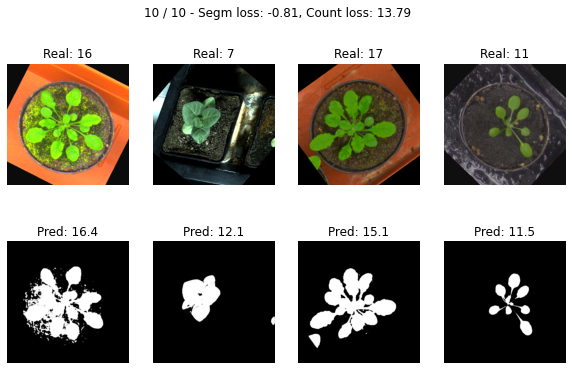

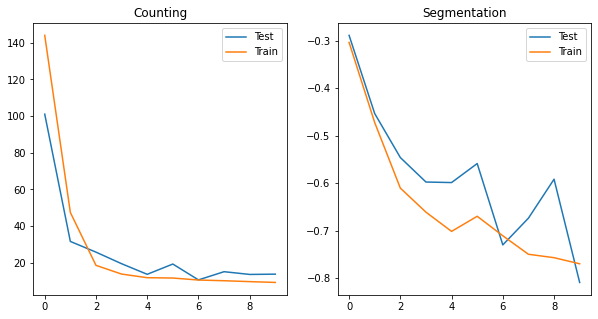

In [ ]:
history = train(model_segm, model_count, epochs, loss_function, optimizer_segm, optimizer_count, train_dl, test_dl)

## Evaluation

In [ ]:
## Evaluation functions to be added

def iou(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return iou

In [ ]:
import torch.nn.functional as F

# Create padding functions to make input images compatible with models

PAD_BASE = 16

def pad_to(x, stride):
    h, w = x.shape[-2:]

    if h % stride > 0:
        new_h = h + stride - h % stride
    else:
        new_h = h
    if w % stride > 0:
        new_w = w + stride - w % stride
    else:
        new_w = w

    lh, uh = int((new_h - h) / 2), (new_h - h) - int((new_h - h) / 2)
    lw, uw = int((new_w - w) / 2), (new_w - w) - int((new_w - w) / 2)
    pads = (lw, uw, lh, uh)

    out = F.pad(x, pads, "constant", 0)

    return out, pads

def unpad(x, pad):
    if pad[2] + pad[3] > 0:
        x = x[:, :, pad[2]: -pad[3], :]
    if pad[0] + pad[1] > 0:
        x = x[:, :, :, pad[0]: -pad[1]]
    return x

In [ ]:
from sklearn.metrics import accuracy_score

model_segm.eval()
model_count.eval()

preprocessing = transforms.Compose([torch.Tensor, transforms.transforms.Resize((480, 480))])

eval_imgs, eval_masks, eval_counts = train_imgs[train_len:], train_masks[train_len:], train_counts[train_len:]

with torch.no_grad():
    all_iou_scores = []
    all_mse_scores = []
    all_acc_scores = []

    for imgs, masks, counts in zip(eval_imgs, eval_masks, eval_counts):
        imgs, masks = preprocessing(imgs).to(device), preprocessing(masks).to(device)
        # Evaluate segmentation
        output_segm = model_segm(imgs.unsqueeze(0))

        # Evaluate counts
        output_count = model_count(torch.cat((imgs.unsqueeze(0), masks.unsqueeze(0).unsqueeze(0)), dim=1)).squeeze(1)
        
        iou_score = iou(torch.round(output_segm.cpu()), masks.cpu())
        acc_score = int(output_count.item() == counts)
        mse_score = (output_count.item() - counts) ** 2

        all_iou_scores.append(iou_score)
        all_acc_scores.append(acc_score)
        all_mse_scores.append(mse_score)
    

print(f'IOU: {sum(all_iou_scores) / len(eval_imgs) :.2f}, \
      MSE: {sum(all_iou_scores) / len(eval_imgs) :.2f}, \
      Accuracy: {sum(all_acc_scores) / len(eval_imgs) :.2f}')

## Build web demo with Gradio library

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
import os


def predict_leaf_number(img):
    """
    :param img: png image to predict leaf number
    """

    img = np.moveaxis(img, [2], [0]) / 255
    preprocessing = transforms.Compose([torch.Tensor,
      transforms.Resize((480, 480))])
    
    img = preprocessing(img).unsqueeze(0).to(device)
    mask = model_segm(img)
    return int(model_count(torch.cat((img, mask), axis=1)).item())


with gr.Blocks() as demo:

    gr.Markdown("# Leaf counter with UNet++ and ResNet50")

    with gr.Row():
        im = gr.Image()
        txt = gr.Textbox(value="", label="Output")

    btn = gr.Button(value="Count leafs")
    btn.click(predict_leaf_number, inputs=[im], outputs=[txt])

    gr.Markdown("## Image Examples")
    gr.Examples(
        examples=["./examples/leaf_im.png"],
        inputs=im,
        outputs=txt,
        fn=predict_leaf_number,
        cache_examples=True,
    )

if __name__ == "__main__":
    demo.launch()


In [ ]:
from sklearn.metrics import accuracy_score

model_segm.eval()
model_count.eval()

device = 'cpu'

preprocessing = transforms.Compose([torch.Tensor])

eval_imgs, eval_masks, eval_counts = train_imgs[train_len:], train_masks[train_len:], train_counts[train_len:]

with torch.no_grad():
    all_iou_scores = []
    all_mse_scores = []
    all_acc_scores = []

    for imgs, masks, counts in zip(eval_imgs, eval_masks, eval_counts):
        imgs, masks = preprocessing(imgs).to(device), preprocessing(masks).to(device)
        imgs, masks = pad_to(imgs, PAD_BASE)[0], pad_to(masks, PAD_BASE)[0]
        # Evaluate segmentation
        output_segm = model_segm(imgs.unsqueeze(0))

        # Evaluate counts
        output_count = model_count(torch.cat((imgs.unsqueeze(0), masks.unsqueeze(0).unsqueeze(0)), dim=1)).squeeze(1)
        
        iou_score = iou(torch.round(output_segm.cpu()), masks.cpu())
        acc_score = int(output_count.item() == counts)
        mse_score = (output_count.item() - counts) ** 2

        all_iou_scores.append(iou_score)
        all_acc_scores.append(acc_score)
        all_mse_scores.append(mse_score)

        f.set_figheight(7)
        f.set_figwidth(15)
    

print(f'IOU: {sum(all_iou_scores) / len(eval_imgs) :.2f}, \
      MSE: {sum(all_iou_scores) / len(eval_imgs) :.2f}, \
      Accuracy: {sum(all_acc_scores) / len(eval_imgs) :.2f}')
